In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
%matplotlib inline
import plotly.graph_objects as go
from ripser import ripser
from persim import plot_diagrams

from plot import *

import sys
sys.path.append("../../")
from DREiMac.dreimac.toroidalcoords import *

In [4]:
# load data

ts = []
imgs = []
downscale=4
less = 4

from PIL import Image, ImageEnhance

for i in range(100001,108100+1,4):
    image = Image.open("data/videos/data/s1_" + str(i) + ".jpg")
    l, h = image.size
    im = image.resize((l//downscale, h//downscale))
    enhancer = ImageEnhance.Brightness(im)
    factor = 1.3
    im = enhancer.enhance(factor)
    imgs.append(im)
    x = np.array(im)
    ts.append(x.reshape(x.shape[0] * x.shape[1] * x.shape[2]))

ts = np.array(ts)
imgs = np.array(imgs)

/var/folders/54/vxgwxr5943zb3yr6mmpzm4tw0000gn/T/ipykernel_32105/414515894.py:22: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  imgs = np.array(imgs)
/var/folders/54/vxgwxr5943zb3yr6mmpzm4tw0000gn/T/ipykernel_32105/414515894.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imgs = np.array(imgs)


In [5]:
d = 4
tau = 1
W = sw(ts, d, tau)
n = W.shape[0]
W = W.reshape(n,W.shape[1] * W.shape[2])

In [6]:
# reduce dimensionality to make persistence faster
from sklearn.decomposition import PCA 

pca = PCA(n_components=10)
X = pca.fit_transform(W)

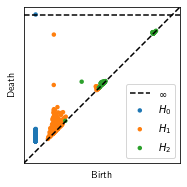

In [7]:
# run persistence

cc = CircularCoords(X, distance_matrix = False, n_landmarks= 1000, prime = 41, maxdim=2)
order_by_prominence = prominence_diagram(cc.dgms_[1])

plt.figure(figsize=(3,3))
plot_diagrams(cc.dgms_)
plt.tight_layout()
plt.xticks([])
_ = plt.yticks([])
#plt.savefig("figures/dy-pd.png", dpi=100, bbox_inches='tight')

In [9]:
# select two most persistent cohomology classes and get two circular coordinates

alpha = 0.3
how_many_coords = 2
cocycles_idxs = list(map(lambda x: [x], order_by_prominence[:how_many_coords] ))
circ_coords, gram_matrix = cc.get_coordinates(perc = alpha, cocycle_idxs= cocycles_idxs, return_gram_matrix=True)

In [10]:
# do lattice reduction to find a linear combination with lower energy, display change of basis matrix

new_circ_coords, new_gram_matrix, change_basis = reduce_circular_coordinates(circ_coords, gram_matrix)
print(change_basis)

[[1. 0.]
 [1. 1.]]


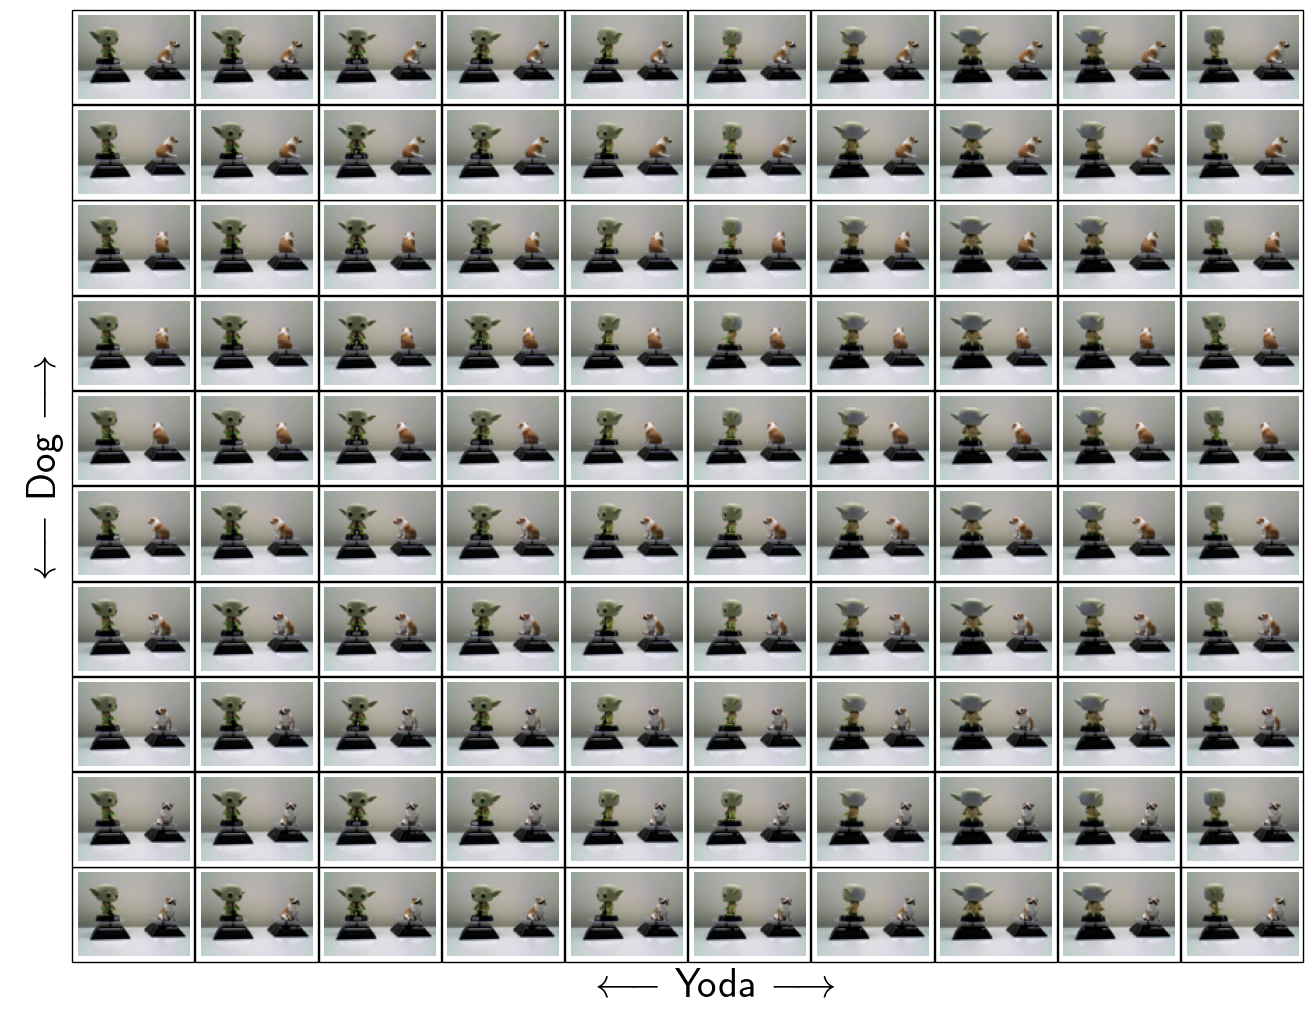

In [35]:
# plot decorrelated coordinates

from matplotlib.offsetbox import OffsetImage, AnnotationBbox

plt.rcParams['text.usetex'] = True
x_coords = center_circ_coord(new_circ_coords[0])
y_coords = center_circ_coord(new_circ_coords[1])

fig, ax = plt.subplots(figsize=(15.9,12.375))
plt.axis("off")
fig.text(0.57, 0.12, r'$\longleftarrow$ Yoda $\longrightarrow$', ha='center', fontsize=30)
fig.text(0.135, 0.55, r'$\longleftarrow$ Dog $\longrightarrow$', va='center', fontsize=30, rotation=90)

def closest(i,j,x_coords,y_coords,bins_x, bins_y):
    return np.argmin(np.linalg.norm(np.array([i/bins_x,j/bins_y]) - np.vstack((x_coords,y_coords)).T, axis=1))

bins_y = 10
bins_x = 10
for i in range(bins_x):
    for j in range(bins_y):
        idx = closest(i,j,x_coords,y_coords,bins_x,bins_y)
        im = imgs[idx]
        ab = AnnotationBbox(OffsetImage(im, cmap='binary',zoom=1), ((i+1)/bins_x,(j+1)/bins_y))
        ax.add_artist(ab)

#plt.savefig("./figures/yoda-dog-adjusted.png", bbox_inches='tight', dpi=200)


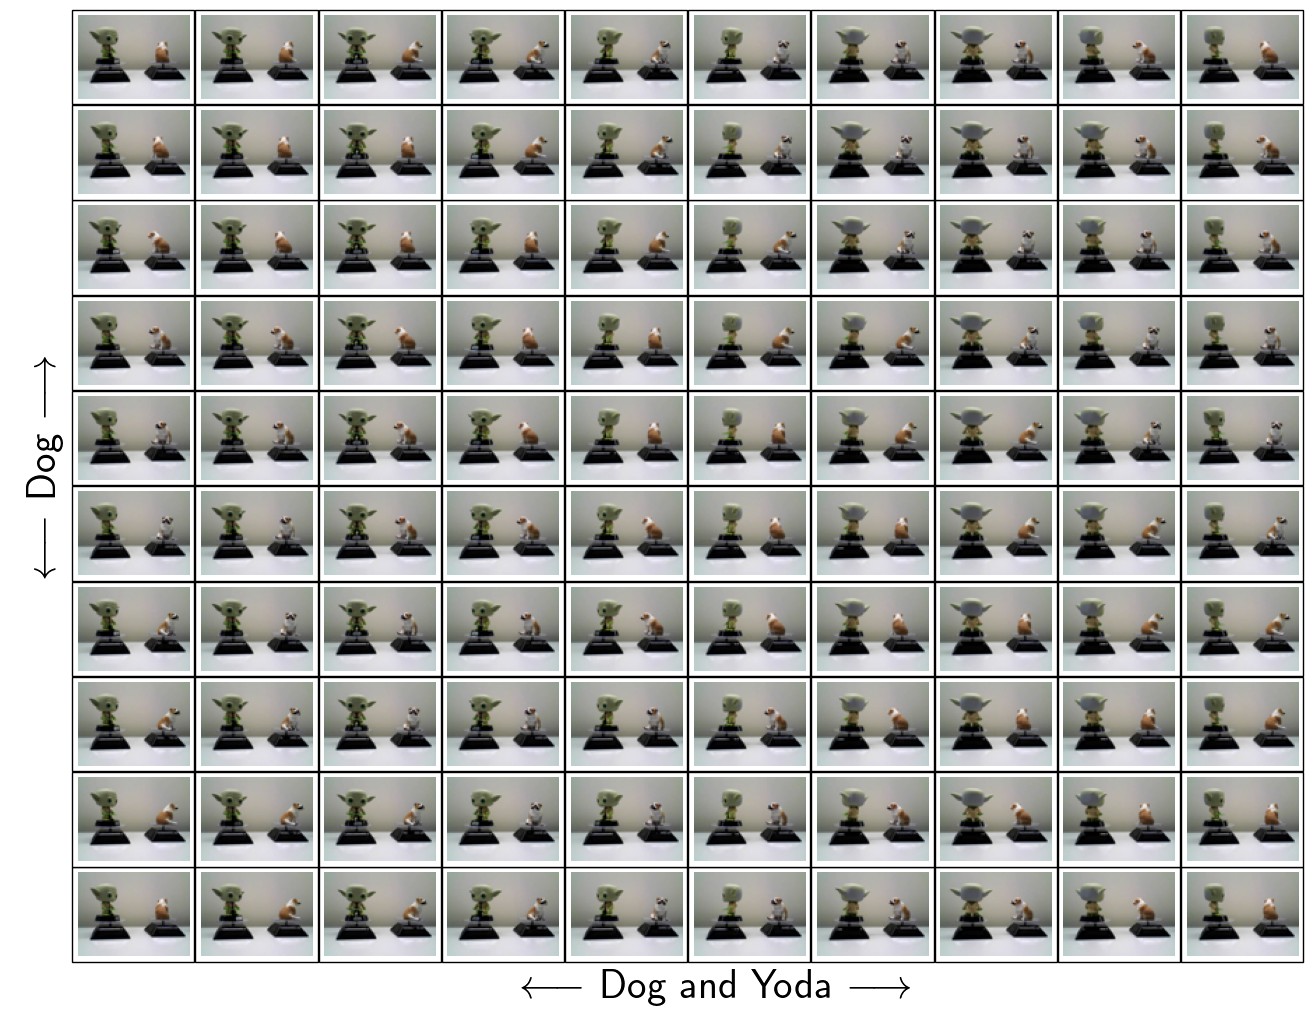

In [36]:
# plot correlated coordinates

x_coords = center_circ_coord(circ_coords[0])
y_coords = center_circ_coord(circ_coords[1])

fig, ax = plt.subplots(figsize=(15.9,12.375))
plt.axis("off")

fig.text(0.57, 0.12, r'$\longleftarrow$ Dog and Yoda $\longrightarrow$', ha='center', fontsize=30)
fig.text(0.135, 0.55, r'$\longleftarrow$ Dog $\longrightarrow$', va='center', fontsize=30, rotation=90)

def closest(i,j,x_coords,y_coords,bins_x, bins_y):
    return np.argmin(np.linalg.norm(np.array([i/bins_x,j/bins_y]) - np.vstack((x_coords,y_coords)).T, axis=1))

bins_y = 10
bins_x = 10
for i in range(bins_x):
    for j in range(bins_y):
        idx = closest(i,j,x_coords,y_coords,bins_x,bins_y)
        im = imgs[idx]
        ab = AnnotationBbox(OffsetImage(im, cmap='binary',zoom=1), ((i+1)/bins_x,(j+1)/bins_y))
        ax.add_artist(ab)

#plt.savefig("./figures/yoda-dog-original.png", bbox_inches='tight', dpi=200)


In [25]:
# confirm that lattice reduction decreased energy and correlation

weight = exp_weight(1000)
graph_type = "k"
k = 10

print(dirichlet_form_gram_matrix(X,circ_coords,weight,k=k,graph_type=graph_type))
print(dirichlet_form_gram_matrix(X,new_circ_coords,weight,k=k,graph_type=graph_type))

[[ 3.0765768  -3.08592243]
 [-3.08592243 10.48731044]]
[[ 3.0765768  -0.00934563]
 [-0.00934563  7.39204237]]
